In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

In [ ]:
# RunRules for m100
nodes = 8 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

# BSE analysis for Stanene monolayer

We compute the first excitonic energy and the absorption spectrum of the monolayer Stanene within the BSE framework.

## Convergence analysis in function of the number of bands

We study the convergence of the low energy part of the absorption spectrum.
The GW correction are included using a scissor on top of the DFT gap.

We perform this analysis for the 18x18x1 k-sampling. We use the RIM_W, the study of the 
convergence of the exciton binding energy with and without the RIM_W will be performed later.

In [54]:
dft_gap = 0.088
gw_gap = 0.184 #
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)

kpoints = 18

scissor 0.096


In [56]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [[25,30],[25,32]]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
for bsebands in BSEBands:
    idd = 'abs-bse-bsebands_%s_%s-bsengblk_%s'%(bsebands[0],bsebands[1],BSENGBlk)
    inp.set_array_variables(BSEBands=bsebands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [57]:
study.ids

['abs-bse-bsebands_25_30-bsengblk_3.0', 'abs-bse-bsebands_25_32-bsengblk_3.0']

In [58]:
#study.runs[0]

In [59]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_3.0
Task [0] ended 
 
Run the task [1] 
Skip the run of abs-bse-bsebands_25_32-bsengblk_3.0
Task [1] ended 
 


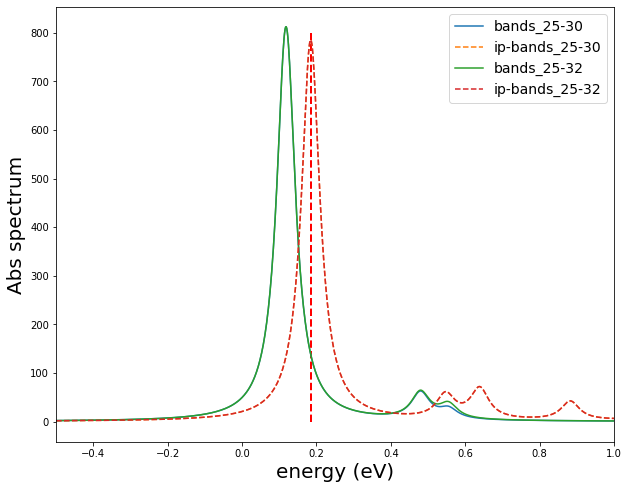

In [63]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSEBands):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    alpha_o_im = data['alpha_o_imag']
    ax.plot(energy,alpha_im,label='bands_%s-%s'%(b[0],b[1])) 
    ax.plot(energy,alpha_o_im,linestyle='--',label='ip-bands_%s-%s'%(b[0],b[1])) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
#ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that also the exciton binding energy is well converged w.r.t. the number of bands

In [64]:
exc_eng = [results[ind].data['Esort_q1_slepc_bse']['energy'] for ind in range(len(BSEBands))]
exc_eng

[array([0.114345, 0.115693, 0.118504, 0.477787, 0.479647, 0.511578,
        0.512583, 0.544306, 0.5547  ]),
 array([0.114167, 0.115673, 0.118485, 0.477604, 0.479527, 0.51005 ,
        0.511133, 0.544296, 0.554687])]

In [65]:
bind_eng = [gw_gap-exc_eng[ind][0] for ind in range(len(BSEBands))]
bind_eng

[0.069655, 0.06983299999999999]

## Convergence analysis in function of BSENGBlk

In [67]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = [3.0,4.0] # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
for bsengblk in BSENGBlk:
    idd = 'abs-bse-bsebands_%s_%s-bsengblk_%s'%(BSEBands[0],BSEBands[1],bsengblk)
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=bsengblk,FFTGvecs=FFTGvecs)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [68]:
study.ids

['abs-bse-bsebands_25_30-bsengblk_3.0', 'abs-bse-bsebands_25_30-bsengblk_4.0']

In [69]:
#study.runs[1]

In [70]:
results = study.run()

Run the selection [0, 1] with the parallel task_groups [[0], [1]] 

Run the task [0] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_3.0
Task [0] ended 
 
Run the task [1] 
Skip the run of abs-bse-bsebands_25_30-bsengblk_4.0
Task [1] ended 
 


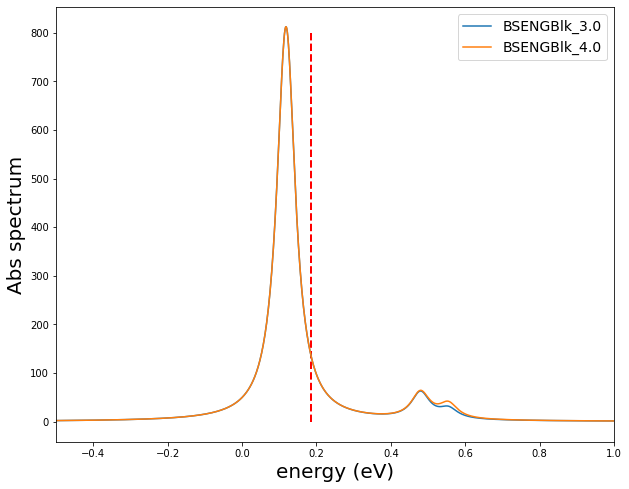

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(BSENGBlk):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='BSENGBlk_%s'%b) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
#ax.set_ylim(-1e-4,4e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

We observe that also the exciton binding energy is well converged w.r.t. the number of bands

In [39]:
exc_eng = [results[ind].data['Esort_q1_slepc_bse']['energy'] for ind in range(len(BSENGBlk))]
exc_eng

[array([0.114345, 0.115693, 0.118504, 0.477787, 0.479647, 0.511578,
        0.512583, 0.544306, 0.5547  ]),
 array([0.11435 , 0.115693, 0.118505, 0.477778, 0.479639, 0.511603,
        0.512607, 0.544308, 0.554705])]

In [40]:
bind_eng = [gw_gap-exc_eng[ind][0] for ind in range(len(BSENGBlk))]
bind_eng

[0.069655, 0.06965]

## Abs spectrum using the true GW band structure

In [42]:
ndbQP = 'pp-allBZ-ngsblkxp_8.0-bndsrnxp_500-gbndrnge_500/ndb.QP'

In [46]:
run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%kpoints

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,32]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(BLongDir=elec_field) #,KfnQP_E=[scissor,1.,1.]
inp.set_scalar_variables(KfnQPdb='E < %s'%ndbQP)

inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     

idd = 'abs-bse-gw-bsebands_%s_%s-bsengblk_%s'%(BSEBands[0],BSEBands[1],BSENGBlk)
inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [53]:
#study.runs[0]

In [48]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F abs-bse-gw-bsebands_25_32-bsengblk_3.0.in -J "abs-bse-gw-bsebands_25_32-bsengblk_3.0,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles-nbnds_500" -C abs-bse-gw-bsebands_25_32-bsengblk_3.0
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500/ ; sbatch job_abs-bse-gw-bsebands_25_32-bsengblk_3.0.sh
computation abs-bse-gw-bsebands_25_32-bsengblk_3.0 is running...
computation abs-bse-gw-bsebands_25_32-bsengblk_3.0 ended
Run performed in 08m-37s
Task [0] ended 
 


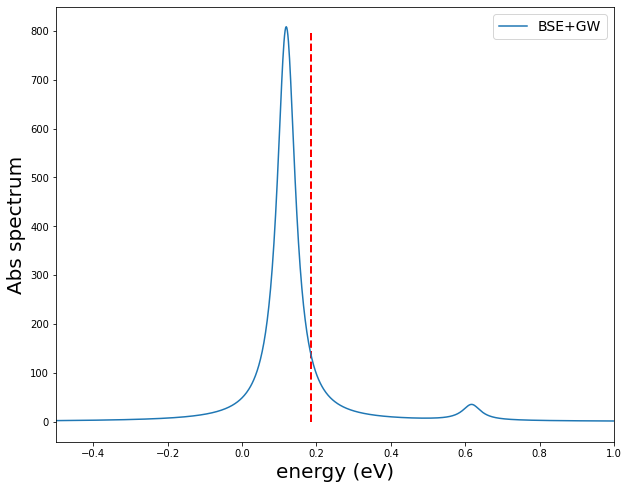

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['alpha_q1_slepc_bse']
energy = data['energy']
alpha_im = data['alpha_imag']
ax.plot(energy,alpha_im,label='BSE+GW') 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

In [51]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.115213, 0.116287, 0.119093, 0.576244, 0.606878, 0.61707 ,
       0.618265, 0.620927])

In [52]:
bind_eng = gw_gap-exc_eng[0]
bind_eng

0.068787

The effect of including the GW correction is a small modification of the peak at 0.6 eV.

## Convergence analysis in function of the k-points sampling

We perform the convergence analysis of the abs spectrum and of the exciton binding energy
in function of the k-sampling. We perform this analysis both with and without the RIM_W.

At this level we use the bands from 25 to 30 with the scissor correction.

In [4]:
dft_gap = 0.088
gw_gap = 0.184 #
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)

kpoints = [18,42,60]

scissor 0.096


In [10]:

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 40. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=4,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500/'%k
    inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
    #inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
    inp.activate_RIM_W()   
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
    inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
    inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
    inp.set_scalar_variables(BSEprop= 'abs esrt')
    inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
    inp.set_scalar_variables(BS_CPU='16.2.1',BS_ROLEs= 'k.eh.t')     
    idd = 'abs-bse-kpoints_%s'%k
    inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles-nbnds_500'],reformat=False)

Initialize a Dataset with 4 parallel tasks


In [11]:
study.runs[2]

{'label': 'Dataset',
 'run_dir': 'GW_analysis-ONCV/kpoints_60-nbnds_500/',
 'num_tasks': 4,
 'verbose': True,
 'skip': True,
 'input': {'args': 'yambo -r -o b -k sex -y s',
  'folder': 'GW_analysis-ONCV/kpoints_60-nbnds_500/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut',
   'bse',
   'optics',
   'bss',
   'WRbsWF',
   'photolum',
   'RIM_W'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [200, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'BSENGexx': [40.0, 'Ha'],
   'BSENGBlk': [3.0, 'Ha'],
   'BEnSteps': [1000, ''],
   'BSSNEig': [20, ''],
   'BSSEnTarget': [0.0, 'eV'],
   'BSSSlepcMaxIt': [0.0, ''],
   'CUTGeo': 'slab z',
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 's',
   'BSEprop': 'abs esrt',
   'BSEdips': 'none',
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[25, 30], ''],
   'BEnRan

In [12]:
results = study.run(selection=[0])

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 yambo -F abs-bse-kpoints_18.in -J "abs-bse-kpoints_18,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles-nbnds_500" -C abs-bse-kpoints_18
slurm submit:  cd GW_analysis-ONCV/kpoints_18-nbnds_500/ ; sbatch job_abs-bse-kpoints_18.sh
computation abs-bse-kpoints_18 is running...
computation abs-bse-kpoints_18 ended
Run performed in 02m-27s
Task [0] ended 
 


KeyError: 1

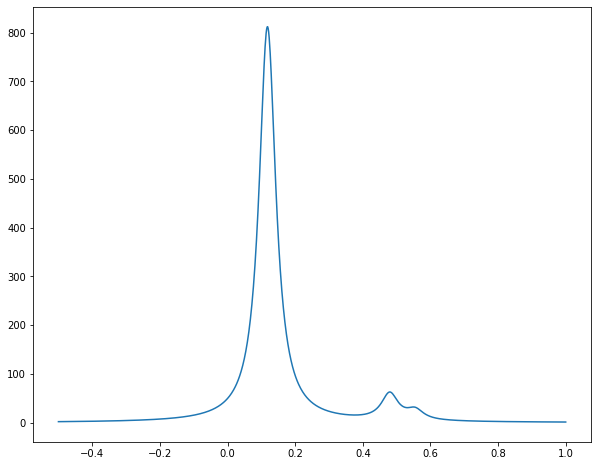

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

for ind,b in enumerate(kpoints):
    data = results[ind].data['alpha_q1_slepc_bse']
    energy = data['energy']
    alpha_im = data['alpha_imag']
    ax.plot(energy,alpha_im,label='kpoints_%s'%b) 
ax.vlines(gw_gap,-1,800,linestyles='--',color='red',linewidth=2)
ax.set_xlim(-0.5,1)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

In [ ]:
#########################################################################

First we build and init the run directories and perform link of the ndb database computed
in the GW analysis

In [7]:
kpoints = [18] #[18,42,60]

for k in kpoints:
    source_dir = 'DFT_analysis/kpoints_%s-nbnds_500.save'%k
    run_dir = 'GW_analysis-ONCV/kpoints_%s-nbnds_500'%k
    Tools.init_yambo_run_dir(Tools.make_p2y(source_dir),run_dir=run_dir)

SAVE folder DFT_analysis/kpoints_72-nbnds_500.save/SAVE already present. No operations performed.
SAVE folder already present in BSE_analysis/kpoints_72-nbnds_500. No operations performed.


We create a link of the folders with the ndb_em1d and with the ndb_rim_cutoff databases created in the _GW_analysis_ in the _BSE_analysis_ folder

In [11]:
def find_ndbs(path):
    ndbs =  []
    files = os.listdir(path)
    for f in files:
        if 'ndb_em1d' in f or 'ndb_rim' in f : ndbs.append(os.path.abspath(os.path.join(path,f)))
    return ndbs

def make_link(ndbs,dest):
    abs_dest = os.path.abspath(dest)
    for ndb in ndbs:
        ndb_name = ndb.split('/')[-1]
        target = os.path.join(abs_dest,ndb_name)
        if not os.path.isdir(target):
            print(ndb,target)
            os.symlink(ndb,target,target_is_directory=True)

In [12]:
for k in kpoints:
    ndbs = find_ndbs('GW_analysis/kpoints_%s-nbnds_500/'%k)
    make_link(ndbs,'BSE_analysis/kpoints_%s-nbnds_500/'%k)

/m100_work/IscrC_PrExIn/Stanene/GW_analysis/kpoints_72-nbnds_500/ndb_em1d-ngsblkxp_8.0-bndsrnxp_500 /m100_work/IscrC_PrExIn/Stanene/BSE_analysis/kpoints_72-nbnds_500/ndb_em1d-ngsblkxp_8.0-bndsrnxp_500
/m100_work/IscrC_PrExIn/Stanene/GW_analysis/kpoints_72-nbnds_500/ndb_rim_cutoff /m100_work/IscrC_PrExIn/Stanene/BSE_analysis/kpoints_72-nbnds_500/ndb_rim_cutoff


## BSE convergence analysis

We test the optimal BSE parameters by constructing the absorption spectrum. 
In this way we analyze the effects of the relevant parameters of a BSE calculation
and we study the convergence w.r.t to the $k$-points sampling.

The analysis is performed on-top of the DFT computations using a scissor to reproduce the 
GW gap

In [28]:
dft_gap = 0.077
gw_gap = 0.176 #
scissor = gw_gap-dft_gap # eV
print('scissor',scissor)
kpoints = [18,42,60]

scissor 0.09899999999999999


We perform this analysis in the 18x18x1 grid using the slepc solver and we are
interested in the first excitonic energy.

We have analyzed the convergence of the exciton energy w.r.t the BSENGBlk value and the
number of BSEBands. The values reported below ensure convergence.

In [29]:
k = kpoints[2]
run_dir = 'BSE_analysis/kpoints_%s-nbnds_500/'%k

RandGvec = 200
Randqpts = 5e6
RandGvecW = 10
EXXRLvcs = 40. # Ha
EXXRLVcs_units = 'Ha'

BSENGBlk = 3.0 # Ha  value of the BSENGBlk variable (it can be reduced w.r.t the NGsBlkXs!)
EXXRLvcs = 60. # Ha use this value for the BSENGexx variable
FFTGvecs = 30. # Ha
elec_field = [1.,0.,0.]
BSEBands = [25,30] #,[27,30],[25,32]]
BEnRange = [-0.5,1] # eV
BEnSteps = 1000
BSSNEig = 20 # number of excitonic eigenvalues
damping = [0.03,0.03] # eV

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

#inp = I.YamboInput('yambo -r -o b -k sex -y s',folder=run_dir)
#inp = I.YamboInput('mpirun -np 1 yambo -r -o b -k sex -y s',folder=run_dir)
inp.activate_RIM_W()   
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_array_variables(units='Ha',BSENGexx=EXXRLvcs,BSENGBlk=BSENGBlk,FFTGvecs=FFTGvecs)
inp.set_array_variables(BLongDir=elec_field,KfnQP_E=[scissor,1.,1.])
inp.set_array_variables(BSEBands=BSEBands,BEnSteps=BEnSteps,BSSNEig=BSSNEig)
inp.set_array_variables(units='eV',BEnRange=BEnRange,BDmRange=damping)
inp.set_scalar_variables(BSEprop= 'abs esrt')
#inp.set_scalar_variables(DBsIOoff='BS') # turn off the I/O of the BSE kernel
inp.set_scalar_variables(BS_CPU='32.1.1',BS_ROLEs= 'k.eh.t')     
#inp['variables']['BS_ROLEs'] = 'k.eh.t' 
#inp['variables']['BS_CPU'] = '4.8.1' # 2 nodes ismhpc and 8 nodes m100
#inp['variables']['BS_CPU'] = '1.8.1' # 2 nodes m100
idd = 'bse_slepc_test'
study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
    jobname=[idd,'ndb_em1d-ngsblkxp_8.0-bndsrnxp_500','ndb_rim_cutoff','ndb_dipoles'],reformat=False)

Initialize a Dataset with 1 parallel tasks


In [30]:
study.runs[0]

{'label': 'Dataset',
 'run_dir': 'BSE_analysis/kpoints_72-nbnds_500/',
 'num_tasks': 1,
 'verbose': True,
 'skip': True,
 'input': {'args': 'mpirun -np 1 yambo -r -o b -k sex -y s',
  'folder': 'BSE_analysis/kpoints_72-nbnds_500/',
  'filename': 'yambo.in',
  'arguments': ['rim_cut',
   'bse',
   'optics',
   'bss',
   'WRbsWF',
   'photolum',
   'RIM_W'],
  'variables': {'DIP_Threads': [0.0, ''],
   'X_Threads': [0.0, ''],
   'K_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [200, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'BSENGexx': [60.0, 'Ha'],
   'BSENGBlk': [3.0, 'Ha'],
   'BEnSteps': [1000, ''],
   'BSSNEig': [20, ''],
   'BSSEnTarget': [0.0, 'eV'],
   'BSSSlepcMaxIt': [0.0, ''],
   'CUTGeo': 'slab z',
   'BSKmod': 'SEX',
   'BSEmod': 'resonant',
   'BSSmod': 's',
   'BSEprop': 'abs esrt',
   'BSEdips': 'none',
   'CUTBox': [[0.0, 0.0, 0.0], ''],
   'BSEQptR': [[1, 1], ''],
   'BSEBands': [[25, 30], ''],
   'B

In [ ]:
results = study.run()

Run the selection [0] with the parallel task_groups [[0]] 

Run the task [0] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F bse_slepc_test.in -J "bse_slepc_test,ndb_em1d-ngsblkxp_8.0-bndsrnxp_500,ndb_rim_cutoff,ndb_dipoles" -C bse_slepc_test
slurm submit:  cd BSE_analysis/kpoints_72-nbnds_500/ ; sbatch job_bse_slepc_test.sh
computation bse_slepc_test is running...
Submitted batch job 8937144


Result for the 72x72x1

In [32]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.098791, 0.163815, 0.166006, 0.16756 , 0.169357, 0.172309])

In [33]:
bind_eng = gw_gap-exc_eng[0]
bind_eng

0.07720899999999999

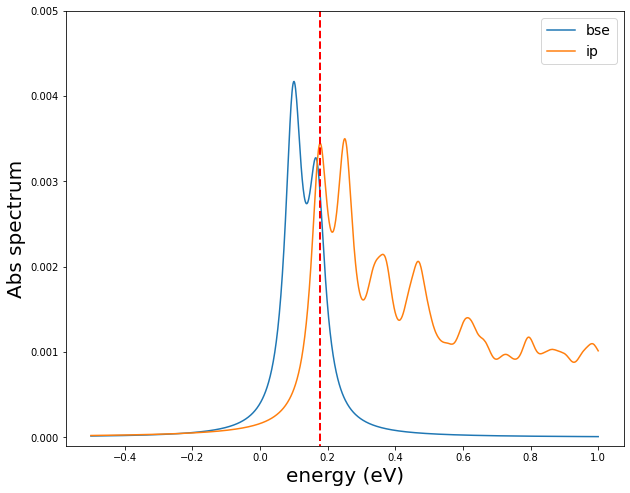

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['eps_q1_slepc_bse']
energy = data['energy']
eps_im = data['eps_imag']
eps_o_im = data['eps_o_imag']
ax.plot(energy,eps_im,label='bse') 
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(gw_gap,-1,10,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,5e-3)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Result for the 30x30x1

In [20]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.099427, 0.100832, 0.294652, 0.320013, 0.331203, 0.332561,
       0.336927])

In [21]:
bind_eng = gw_gap-exc_eng[0]
bind_eng

0.07657299999999999

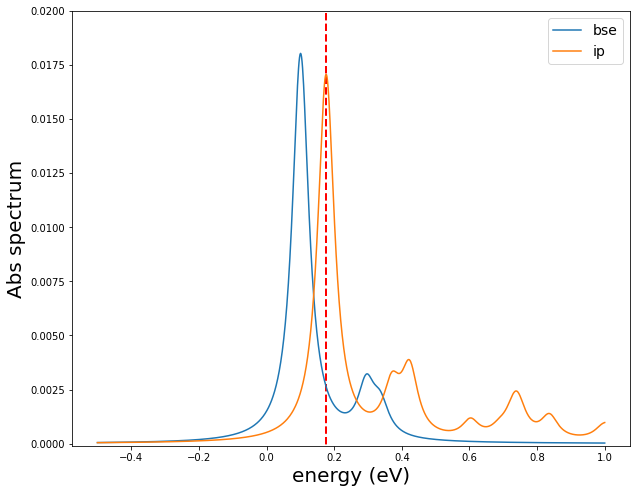

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['eps_q1_slepc_bse']
energy = data['energy']
eps_im = data['eps_imag']
eps_o_im = data['eps_o_imag']
ax.plot(energy,eps_im,label='bse') 
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(gw_gap,-1,10,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,2e-2)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Result for the 18x18x1

In [17]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.117597, 0.12094 , 0.313112, 0.314991, 0.519655, 0.549074,
       0.557604])

In [9]:
exc_eng = results[0].data['Esort_q1_slepc_bse']['energy']
exc_eng

array([0.117597, 0.12094 , 0.313112, 0.314991, 0.519655, 0.549073,
       0.557604])

In [10]:
bind_eng = gw_gap-exc_eng[0]
bind_eng

0.058403

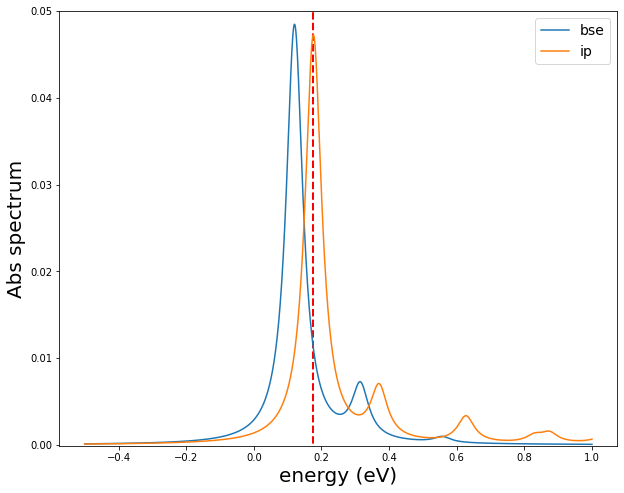

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))

data = results[0].data['eps_q1_slepc_bse']
energy = data['energy']
eps_im = data['eps_imag']
eps_o_im = data['eps_o_imag']
ax.plot(energy,eps_im,label='bse') 
ax.plot(energy,eps_o_im,label='ip') 
ax.vlines(gw_gap,-1,10,linestyles='--',color='red',linewidth=2)
#ax.set_xlim(1.5,4)
ax.set_ylim(-1e-4,5e-2)
ax.set_ylabel('Abs spectrum',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.legend(fontsize=14)

Now we test the convergence of the excitonic energy w.r.t the k-points sampling